In [1]:
from statistics import mode
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
from data_processing.VoiceBankDEMAND import VoiceBandDEMAND
from data_processing.feature_extractor import FeatureExtractor
from utils import prepare_input_features, read_audio
from model import build_model, build_model_lstm
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

from tensorflow.python.client import device_lib
import keras.models

device_lib.list_local_devices()

tf.random.set_seed(999)
np.random.seed(999)

# model_name = 'cnn'
model_name = 'lstm'

path_to_dataset = f"./records_{model_name}"


if model_name == "cnn":
  windowLength = 256
  overlap      = round(0.25 * windowLength) # overlap of 75%
  ffTLength    = windowLength
  inputFs      = 48e3
  fs           = 16e3
  numFeatures  = ffTLength//2 + 1
  numSegments  = 8
  model = build_model(l2_strength=0.0)

if model_name == "lstm":
  windowLength = 512
  overlap      = round(0.5 * windowLength) # overlap of 75%
  ffTLength    = windowLength
  inputFs      = 48e3
  fs           = 16e3
  numFeatures  = ffTLength//2 + 1
  numSegments  = 63 # 1 sec in 512 window, 256 hop, sr = 16000 Hz
  model = build_model_lstm()


2022-09-29 18:49:29.974052: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 18:49:30.905502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 18:49:30.944560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 18:49:30.949253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negati

Found GPU at: /device:GPU:0
windowLength: 512
overlap: 256
ffTLength: 512
inputFs: 48000.0
fs: 16000.0
numFeatures: 257
numSegments: 63


2022-09-29 18:49:31.801350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 18:49:31.802533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 18:49:31.803249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 18:49:31.803966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 18:49:31.804922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [2]:
model.summary()
model_path = Path(f'./result/{model_name}/20220928-140610_step_200/')

# Model load
model = keras.models.load_model(model_path / "model")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 63, 257)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.compat.v1.squeeze (TFOpLamb  (None, 63, 257)     0           ['input_1[0][0]']                
 da)                                                                                              
                                                                                                  
 mel_spec (MelSpec)             (None, 63, 128)      0           ['tf.compat.v1.squeeze[0][0]']   
                                                                                              

In [3]:

voiceBankDEMAND_basepath = '/Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791'
voiceBankDEMAND_basepath = '/home/daniel0413/workplace/project/SpeechEnhancement/TinyML/data/VoiceBankDEMAND'

voiceBank = VoiceBandDEMAND(voiceBankDEMAND_basepath, val_dataset_percent=0.3)
clean_test_filenames, noisy_test_filenames = voiceBank.get_test_filenames()

clean_file = clean_test_filenames[5] # select file
noisy_file = noisy_test_filenames[5]

clean_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/clean.wav"
noisy_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/dirty.wav"
bose_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/proc.wav"
boseAudio, sr = read_audio(bose_file, fs)

print("Clean: ", clean_file)
print("Noisy: ", noisy_file)

cleanAudio, sr = read_audio(clean_file, fs)
noisyAudio, sr = read_audio(noisy_file, fs)

cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

File example:
Clean:  /home/daniel0413/workplace/project/SpeechEnhancement/TinyML/data/VoiceBankDEMAND/clean_testset_wav/p232_001.wav The number:  824
Noisy:  /home/daniel0413/workplace/project/SpeechEnhancement/TinyML/data/VoiceBankDEMAND/noisy_testset_wav/p232_001.wav The number:  824
# of Noise testing files: 824
Clean:  /home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/clean.wav
Noisy:  /home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/dirty.wav
Min: 1.7397038e-07 Max: 24.38301


In [4]:
if model_name == "cnn":
    predictors = prepare_input_features(noise_stft_features, numSegments, numFeatures)

    predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
    predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
    print('predictors.shape:', predictors.shape)

    STFTFullyConvolutional = model.predict(predictors)
    print(STFTFullyConvolutional.shape)

elif model_name == "lstm":
  predictors = prepare_input_features(noise_stft_features, numSegments, numFeatures)
  predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], predictors.shape[2]))
  predictors = np.transpose(predictors, (2, 0, 1)).astype(np.float32)
  predictors = np.transpose(predictors, (0, 2, 1))
  predictors = np.expand_dims(predictors, axis=1)

  STFTFullyConvolutional = model.predict(predictors)
  STFTFullyConvolutional = STFTFullyConvolutional[..., -1, :]
  STFTFullyConvolutional = np.squeeze(STFTFullyConvolutional)
  
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

# segment, feature, 1, 1
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
# ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

print(denoisedAudioFullyConvolutional.shape)

12/12 [==============================] - 1s 3ms/step


2022-09-29 18:49:35.063546: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-29 18:49:35.146917: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Min: -0.30445755 Max: 0.29277226
(98048,)


Text(0.5, 1.0, 'Denoised Audio')

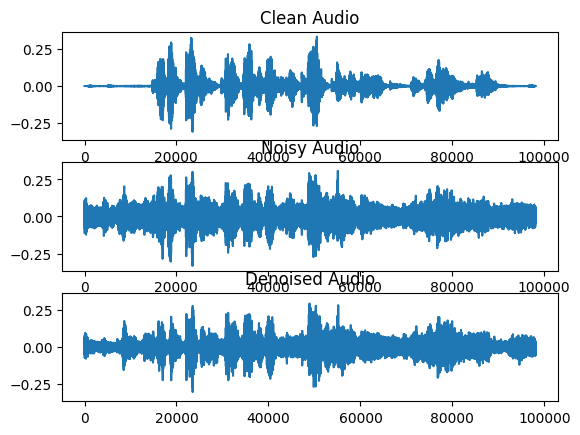

In [5]:
# plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")


In [6]:
import IPython.display as ipd
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

In [7]:
ipd.Audio(data=cleanAudio, rate=fs) # load a local WAV file

In [8]:
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [9]:
ipd.Audio(data=boseAudio, rate=fs)